In [1]:
import sys
sys.path.append("/glade/work/zhixing/python_scripts/SOM-SEASONAL/User-defined/")
from Synoptic_regimes import *


In [2]:
map_data_700, tod_map_hgt_700, precip, uwind_700, vwind_700, temp_700, IVMFT_u, IVMFT_v,  lat_era5, lon_era5 = read_ERA5_data()

# #-- read the processed wrf output for accumulated snow/precipitation data (SNOWNC/ RAINNC)
rain, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'precipitation') ## extract the hourly precip from WRF output
snow, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'snow')


In [4]:
NODE1_NUM = 2; NODE2_NUM = 2
# #-- running the self-organizing map, get the cluster results for each map
# w_x, w_y = SOM_processing(NODE1 = NODE1_NUM , NODE2 = NODE2_NUM , sigma = 1.1, l_r = 0.4, n_f = 'gaussian',r_s = 59, iterations=400, max_iter=1000)
w_x = np.load('/glade/work/zhixing/python_scripts/temp_w_x.npy')
w_y = np.load('/glade/work/zhixing/python_scripts/temp_w_y.npy')


# # #-- get the index for each node
dic_cluster, dic_time = Link_processing(NODE1=NODE1_NUM , NODE2 = NODE2_NUM, w_x = w_x, w_y = w_y, time = time)

Link data with cluster	 Finished...



In [5]:
%%time
###--------------------------$$$$$$$$$$$$$$$$$$

def load_integrated_data(input_vars_list):
    """ This function aims to load the integrated hydrometeor data and projected on each node """
    
    vars_list = input_vars_list
    
    vars_dict = {}
    for var in vars_list:
        temp_list = []
        for i in range(6):
            varname = var + str(i) + ".npy"  ## the numpy array 
            var_array = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/" + varname) ## the path of the dataset, load the data
            temp_list.append(var_array)

        temp2 = np.array(temp_list)
        dim0  = temp2.shape[0]; dim1  = temp2.shape[1]; dim2  = temp2.shape[2]; dim3  = temp2.shape[3]
        full_array = temp2.reshape(dim0 * dim1, dim2, dim3) ## dim0*dim1 = time coordinate; dim2 and dim3 are spatial coordinate (lat / lon)

        temp_dic = {}
        for locs, index in dic_cluster.items():

            time_avg_maps  = np.nanmean(full_array[index], axis = 0) ## select the variables based on the index (for each node); then we average the time dimension and get the composite pattern
            temp_dic[locs] = time_avg_maps

        vars_dict[var] = temp_dic ## {'variable 1':{(0,0): 2d array, (0,1): 2d array, (1,0): 2d array, (1,1): 2d array}, 'variable 2'...}
    
    snow_temp_dic = {}; precip_temp_dic = {}; s_p_ratio_temp_dic = {}
    for locs, index in dic_cluster.items():
        ## select the composite node data
        ## here, for linear regression analysis, and avoid the extreme value effects
        ## (5%-95%) data are kept
        # np.nanquantile
        snow_temp_dic[locs]    = np.nanmean(snow[index], axis = 0)
        precip_temp_dic[locs]  = np.nanmean(rain[index], axis = 0)
        s_p_ratio_temp_dic[locs]  = np.nanmean(snow[index], axis = 0) / np.nanmean(rain[index], axis = 0)
        
    vars_dict['snow']   =  snow_temp_dic
    vars_dict['precip'] =  precip_temp_dic
    vars_dict['s_p_ratio'] = s_p_ratio_temp_dic
        
    return vars_dict  

input_vars_list = ['slw_qcloud_path'] #, 'slw_qrain_path', 'liquid_water_path', 'ice_water_path']

vars_dict = load_integrated_data(input_vars_list) ## the structure of this dictionary was {'variable 1':{(0,0): 2d array, (0,1): 2d array, (1,0): 2d array, (1,1): 2d array}, 'variable 2'...}

CPU times: user 18.2 s, sys: 22.8 s, total: 41 s
Wall time: 41.8 s


In [8]:
%%time
##-------------------------
##-------------------------
def get_ter_lvls(step):
    """ This function aims to define the number and width of the bin for terrain height """
    
    wrffile  = Dataset("/glade/work/zhixing/wrfout_d02_2017-01-01_00:00:00") ## read the WRF output file
    terrain  = getvar(wrffile, 'ter').values.flatten() ## extract the terrain variable and then flatten the array

    ter_lvl  = np.arange(450, 4150, step)  ## select the levels of terrain; e.g. [450, 550, 650, ..., 4150]; bin width = 100 meters
    plot_ter_lvl = np.arange(500, 4100, step)  ## the median value in each bin is selected for plotting the x-axis; [500, 600, 700, ..., 4100]
    
    
    # ter_lvl = np.arange(250, 3960, step) ## step >= 20 
    # plot_ter_lvl = np.arange(250 + step/2, 3960, step) 
    
    ## for example [350, 450] and then choose the middle point for plotting, representing this range
    
    return ter_lvl, plot_ter_lvl, terrain

################################
ter_lvl, plot_ter_lvl, terrain = get_ter_lvls(step=100) ## get the series of terrain, 100m as a interval

CPU times: user 18.3 ms, sys: 7.08 ms, total: 25.4 ms
Wall time: 155 ms


In [9]:
%%time
def cal_vars_as_func_of_ht(plot_var_list, input_vars_dict):
    """ This function aims to calculate variabels as a function of height """
    
    wrffile  = Dataset("/glade/work/zhixing/wrfout_d02_2017-01-01_00:00:00")
    terrain  = getvar(wrffile, 'ter').values.flatten()
    
    vars_ht_dict  = {}; vars_ht_95_dict = {}; vars_ht_05_dict = {}; vars_ht_75_dict = {}; vars_ht_25_dict = {} ## the dictionary of vars as a function of altitude
    ## the 95 percentile; 5 percentile; 75 percentile; 25 percentile
    for var_name in plot_var_list:
        temp_dic = input_vars_dict[var_name]
        temp_var_ht_dic = {}; temp_var_95_ht_dic = {}; temp_var_05_ht_dic = {}; temp_var_75_ht_dic = {}; temp_var_25_ht_dic = {}; 
        # {(0,0): [a1, a2, a3, ..., an], (0,1): [a1, a2, a3, ..., an],\
        # (1,0): [a1, a2, a3, ..., an], (1,1): [a1, a2, a3, ..., an]}  the a1 is the average values in this bin
        for locs, values in temp_dic.items():
            temp_1d_val = values.flatten()
            temp_list   = []; temp_95_list = []; temp_05_list = []; temp_75_list = []; temp_25_list = []
            for i in range(ter_lvl.shape[0]-1):

                l_ter = ter_lvl[i]
                r_ter = ter_lvl[i+1] ## the edge of the terrain bin width
                sel_ind = np.where((terrain <= r_ter) & (terrain >= l_ter))[0] ## the index selected via terrain height

                ## extract values
                sel_temp_1d_val = temp_1d_val[sel_ind] ## one dimensioanl array
                q95_sel_val     = np.nanquantile(sel_temp_1d_val, 0.95)
                q75_sel_val     = np.nanquantile(sel_temp_1d_val, 0.75)
                avg_sel_val     = np.nanmean(sel_temp_1d_val)
                q05_sel_val     = np.nanquantile(sel_temp_1d_val, 0.05)
                q25_sel_val     = np.nanquantile(sel_temp_1d_val, 0.25)
                temp_list.append(avg_sel_val) ## the mean value for this bin; 
                temp_95_list.append(q95_sel_val); temp_05_list.append(q05_sel_val)
                temp_75_list.append(q75_sel_val); temp_25_list.append(q25_sel_val)

            temp_var_ht_dic[locs] = np.array(temp_list); temp_var_95_ht_dic[locs] = np.array(temp_95_list);  temp_var_05_ht_dic[locs] = np.array(temp_05_list); 
            temp_var_75_ht_dic[locs] = np.array(temp_75_list);  temp_var_25_ht_dic[locs] = np.array(temp_25_list);

        vars_ht_dict[var_name] = temp_var_ht_dic; vars_ht_95_dict[var_name] = temp_var_95_ht_dic; vars_ht_05_dict[var_name] = temp_var_05_ht_dic
        vars_ht_75_dict[var_name] = temp_var_75_ht_dic; vars_ht_25_dict[var_name] = temp_var_25_ht_dic

    return vars_ht_dict, vars_ht_95_dict, vars_ht_05_dict, vars_ht_75_dict, vars_ht_25_dict

plot_vars_list = ['snow','precip', 'slw_qcloud_path', 's_p_ratio']

## get the data as a function of slope
## calculate variables as a function of terrain slope (the idea is that do regional average on the original datasets)
dic_node_ter_var, dic_node_95_ter_var, dic_node_05_ter_var, dic_node_75_ter_var, dic_node_25_ter_var = cal_vars_as_func_of_ht(plot_vars_list, input_vars_dict = vars_dict)


CPU times: user 714 ms, sys: 3.9 ms, total: 718 ms
Wall time: 774 ms


Text(0.96, 0.96, '(b)')

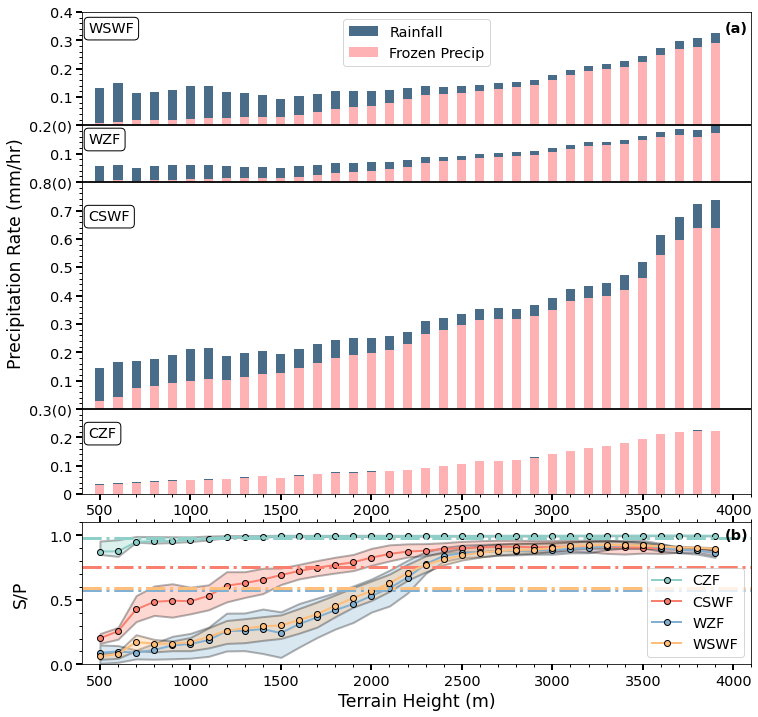

In [11]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(4, 1)
f_ax1 = fig.add_subplot(gs[:3, :])
f_ax2 = fig.add_subplot(gs[3, :])


##=============================
##=============================
##=============================  Extract the variables
line_ratio = dic_node_ter_var['s_p_ratio']

line_ratio_95 = dic_node_95_ter_var['s_p_ratio']
line_ratio_75 = dic_node_75_ter_var['s_p_ratio']
line_ratio_25 = dic_node_25_ter_var['s_p_ratio']
line_ratio_05 = dic_node_05_ter_var['s_p_ratio']

line_rain_00 = dic_node_ter_var['precip'][(0,0)]
line_snow_00 = dic_node_ter_var['snow'][(0,0)]

line_rain_01 = dic_node_ter_var['precip'][(0,1)] 
line_snow_01 = dic_node_ter_var['snow'][(0,1)] 

line_rain_10 = dic_node_ter_var['precip'][(1,0)] 
line_snow_10 = dic_node_ter_var['snow'][(1,0)] 

line_rain_11 = dic_node_ter_var['precip'][(1,1)] 
line_snow_11 = dic_node_ter_var['snow'][(1,1)] 



##=============================
##=============================
##============================= plot the histgram of different variables
bar_rain_00 = f_ax1.bar(plot_ter_lvl, line_rain_00, 50, bottom = 0, color = '#496C88', label = 'Rainfall')
bar_snow_00 = f_ax1.bar(plot_ter_lvl, line_snow_00, 50, bottom = 0, color = '#FEB2B4', label = 'Frozen Precip')

bar_rain_01 = f_ax1.bar(plot_ter_lvl, line_rain_01, 50, bottom = 0.3, color = '#496C88')
bar_snow_01 = f_ax1.bar(plot_ter_lvl, line_snow_01, 50, bottom = 0.3, color = '#FEB2B4')

bar_rain_10 = f_ax1.bar(plot_ter_lvl, line_rain_10, 50, bottom = 1.1, color = '#496C88')
bar_snow_10 = f_ax1.bar(plot_ter_lvl, line_snow_10, 50, bottom = 1.1, color = '#FEB2B4')

bar_rain_11 = f_ax1.bar(plot_ter_lvl, line_rain_11, 50, bottom = 1.3, color = '#496C88')
bar_snow_11 = f_ax1.bar(plot_ter_lvl, line_snow_11, 50, bottom = 1.3, color = '#FEB2B4')



f_ax1.set_yticks(np.arange(0,1.81,0.1))
f_ax1.set_yticklabels(['0','0.1', '0.2','0.3(0)','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8(0)','0.1','0.2(0)','0.1','0.2','0.3','0.4','0.5'])
f_ax1.set_ylabel('Precipitation Rate (mm/hr)',  fontsize = 'xx-large')
f_ax1.tick_params(axis='both',length=6,width=2,labelsize='x-large')
f_ax1.tick_params(which='minor',axis='both',length=3,width=1,labelsize='x-large')
f_ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
f_ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
f_ax1.legend(loc='upper center', fontsize = 'x-large')
f_ax1.set_xlim(400,4100)
f_ax1.set_ylim(0,1.7)
f_ax1.text(.96, .98, '(a)', ha='left', va='top', transform=f_ax1.transAxes, fontsize = 'x-large', fontweight = 'bold')
f_ax1.axhline( 0.3, alpha=0.9,  lw =2, color = 'k')
f_ax1.axhline( 1.1, alpha=0.9,  lw =2, color = 'k')
f_ax1.axhline( 1.3, alpha=0.9,  lw =2, color = 'k')
# f_ax1.axhline( 1.3, alpha=0.9,  lw =2, color = 'k')
f_ax1.text(.01, .14, 'CZF', ha='left', va='top', transform=f_ax1.transAxes, fontsize = 'x-large',bbox=dict(facecolor='none', edgecolor='k', boxstyle='round'))
f_ax1.text(.01, .59, 'CSWF', ha='left', va='top', transform=f_ax1.transAxes, fontsize = 'x-large',bbox=dict(facecolor='none', edgecolor='k', boxstyle='round'))
f_ax1.text(.01, .75, 'WZF', ha='left', va='top', transform=f_ax1.transAxes, fontsize = 'x-large',bbox=dict(facecolor='none', edgecolor='k', boxstyle='round'))
f_ax1.text(.01, .98, 'WSWF', ha='left', va='top', transform=f_ax1.transAxes, fontsize = 'x-large',bbox=dict(facecolor='none', edgecolor='k', boxstyle='round'))


##------------
color_list = ['#8ECFC9','#FA7F6F','#82B0D2','#FFBE7A']
label_list = ['CZF','CSWF','WZF','WSWF']

for i, l_ratio_25, l_ratio, l_ratio_75 in zip(range(4), line_ratio_25.values(), line_ratio.values(), line_ratio_75.values()):
    f_ax2.plot(plot_ter_lvl, l_ratio, color = color_list[i], lw = 2, marker = 'o', mec = 'k', ms =6, label = label_list[i], mew=1)
    f_ax2.axhline(np.nanmean(l_ratio), color = color_list[i], ls = '-.', lw =3)
    f_ax2.fill_between(plot_ter_lvl, l_ratio_25, l_ratio_75, alpha = 0.3, color = color_list[i], ec = 'k', lw=2)
    
    ##------- tick parameters
    f_ax2.tick_params(axis='both',length=6,width=2,labelsize='x-large',top=True)
    f_ax2.tick_params(which='minor',axis='both',length=3,width=1,labelsize='x-large', top=True)
    f_ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    f_ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    f_ax2.legend(loc='lower right', fontsize = 'x-large')
    
f_ax2.set_ylabel("S/P", fontsize = 'xx-large', labelpad = 20)
f_ax2.set_xlabel("Terrain Height (m)", fontsize = 'xx-large')
f_ax2.set_xlim(400,4100)
f_ax2.set_ylim(0,1.1)
f_ax2.text(.96, .96, '(b)', ha='left', va='top', transform=f_ax2.transAxes, fontsize = 'x-large', fontweight = 'bold')
